原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

In [2]:
from keras import backend as K
K.clear_session()

# Generating images
# 生成图像

This notebook contains the second code sample found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


## Variational autoencoders


Variational autoencoders, simultaneously discovered by Kingma & Welling in December 2013, and Rezende, Mohamed & Wierstra in January 2014, 
are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on 
autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas 
from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output 
with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the _same images_ as the 
input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. 
the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most 
commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way 
to compress the input data into fewer bits of information.

## 变分自编码器

自编码器由 Kingma 和 Welling 于 2013 年 12 月 a 与 Rezende、Mohamed 和 Wierstra 于 2014 年 1 月 同时发现，它是一种生成式模型，特别适用于利用概念向量进行图像编辑的任务。它是 一种现代化的自编码器，将深度学习的想法与贝叶斯推断结合在一起。自编码器是一种网络类型， 其目的是将输入编码到低维潜在空间，然后再解码回来。

经典的图像自编码器接收一张图像，通过一个编码器模块将其映射到潜在向量空间，然后再通过一个解码器模块将其解码为与原始图像具有相同尺寸的输出（见图）。然后，使用与输入图像相同的图像作为目标数据来训练这个自编码器，也就是说，自编码器学习对原始输入进行重新构建。通过对代码（编码器的输出）施加各种限制，我们可以让自编码器学到比较有 趣的数据潜在表示。最常见的情况是将代码限制为低维的并且是稀疏的（即大部分元素为 0），在这种情况下，编码器的作用是将输入数据压缩为更少二进制位的信息。


![Autoencoder](data/autoencoder.jpg)


In practice, such classical autoencoders don't lead to particularly useful or well-structured latent spaces. They're not particularly good 
at compression, either. For these reasons, they have largely fallen out of fashion over the past years. Variational autoencoders, however, 
augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They 
have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical 
distribution: a mean and a variance. Essentially, this means that we are assuming that the input image has been generated by a statistical 
process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean 
and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The 
stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every 
point sampled in the latent will be decoded to a valid output.

在实践中，这种经典的自编码器不会得到特别有用或具有良好结构的潜在空间。它们也没有对数据做多少压缩。因此，它们已经基本上过时了。但是，VAE 向自编码器添加了一点统计魔法，迫使其学习连续的、高度结构化的潜在空间。这使得 VAE 已成为图像生成的强大工具。

VAE 不是将输入图像压缩成潜在空间中的固定编码，而是将图像转换为统计分布的参数，即平均值和方差。本质上来说，这意味着我们假设输入图像是由统计过程生成的，在编码和解码过程中应该考虑这一过程的随机性。然后，VAE 使用平均值和方差这两个参数来从分布中随机采样一个元素，并将这个元素解码到原始输入（见下图）。这个过程的随机性提高了其稳健性，并迫使潜在空间的任何位置都对应有意义的表示，即潜在空间采样的每个点都能解码为有效的输出。


![VAE](data/vae.png)


In technical terms, here is how a variational autoencoder works. First, an encoder module turns the input samples `input_img` into two 
parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`. Then, we randomly sample a point `z` 
from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where 
epsilon is a random tensor of small values. Finally, a decoder module will map this point in the latent space back to the original input 
image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` 
(`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close 
points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, 
forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured 
and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: first, a reconstruction loss that forces the decoded samples to match the 
initial inputs, and a regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

从技术角度来说，VAE 的工作原理如下。
* (1) 一个编码器模块将输入样本 input_img 转换为表示潜在空间中的两个参数 z_mean 和z_log_variance。
* (2) 我们假定潜在正态分布能够生成输入图像，并从这个分布中随机采样一个点 z：z = z_mean + exp(z_log_variance) * epsilon，其中 epsilon 是取值很小的随机 张量。
* (3) 一个解码器模块将潜在空间的这个点映射回原始输入图像。

因为 epsilon 是随机的，所以这个过程可以确保，与 input_img 编码的潜在位 置（即 z-mean）靠近的每个点都能被解码为与 input_img 类似的图像，从而迫使潜在空间能够连续地有意义。潜在空间中任意两个相邻的点都会被解码为高度相似的图像。连续性以及潜在空间的低维度，将迫使潜在空间中的每个方向都表示数据中一个有意义的变化轴，这使得潜在空间具有非常良好的结构，因此非常适合通过概念向量来进行操作。

VAE 的参数通过两个损失函数来进行训练：一个是重构损失（reconstruction loss），它迫使解码后的样本匹配初始输入；另一个是正则化损失（regularization loss），它有助于学习具有良好结构的潜在空间，并可以降低在训练数据上的过拟合。我们来快速浏览一下 Keras 实现的 VAE。其大致代码如下所示。


Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`.

它是一个简单的卷积神经网络，将输入图像 x 映射为两个向量 z_mean 和 z_log_var。

In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane（潜在空间的维度：一个二维平面）

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

接下来的代码将使用 z_mean 和 z_log_var 来生成一个潜在空间点 z，z_mean 和 z_log_var 是统计分布的参数，我们假设这个分布能够生成 input_img。这里，我们将一些随意的代码（这些代码构建于 Keras 后端之上）包装到 Lambda 层中。在 Keras 中，任何对象都应该是一个层，所以如果代码不是内置层的一部分，我们应该将其包装到一个Lambda 层（或自定义层）中。


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

下列代码给出了解码器的实现。我们将向量 z 的尺寸调整为图像大小，然后使用几个卷积层来得到最终的图像输出，它和原始图像 input_img 具有相同的大小。

In [5]:
# This is the input where we will feed `z`.（需要将 z 输入到这里）
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units（对输入进行上采样）
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
# 将 z 转换为特征图，使其形状与编码 器模型最后一个 Flatten 层之前的特征图的形状相同
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
# 使用一个 Conv2DTranspose 层和一个Conv2D 层，将 z 解码为与原始输入图像具有相同尺寸的特征图

x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.
# 我们最终获得了与原始输入相同大小的特征映射。

# This is our decoder model.将解码器模型实例化，它将 decoder_input转换为解码后的图像
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
# 将这个实例应用于 z，以得到解码后的 z
z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

我们一般认为采样函数的形式为 loss(input, target)，VAE 的双重损失不符合这种形式。因此，损失的设置方法为：编写一个自定义层，并在其内部使用内置的 add_loss 层方法来创建一个你想要的损失。


In [6]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.（我们不使用这个输出， 但层必须要有返回值）
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.（对输入和解码后的输出调用自定义层，以得到最终的模型输出）
y = CustomVariationalLayer()([input_img, z_decoded])


Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we don't specify an external loss 
at compile time (`loss=None`), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` 
to the model in `fit`).

最后，将模型实例化并开始训练。因为损失包含在自定义层中，所以在编译时无须指定外部损失（即 loss=None），这意味着在训练过程中不需要传入目标数据。（如你所见，我们在调用 fit 时只向模型传入了 x_train。）


In [7]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (


Once such a model is trained -- e.g. on MNIST, in our case -- we can use the `decoder` network to turn arbitrary latent space vectors into 
images:

一旦训练好了这样的模型（本例中是在 MNIST 上训练），我们就可以使用 decoder 网络将任意潜在空间向量转换为图像。


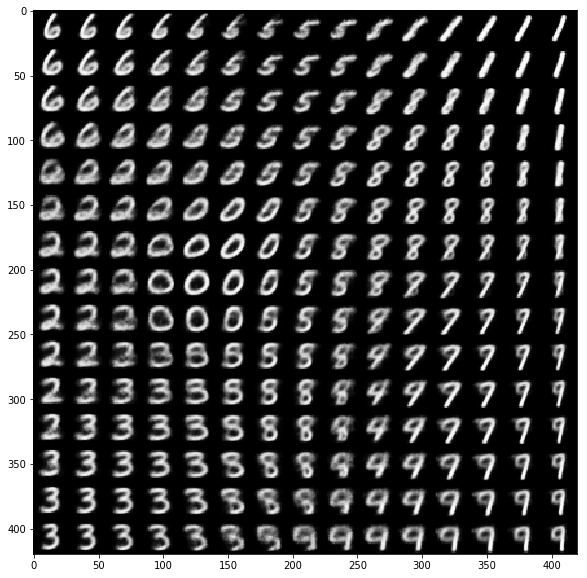

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits（我们将显示 15×15 的数字网格（共 255 个数字））
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian

# 使用 SciPy 的 ppf 函数对线性分隔的坐标进行变换，
# 以生成潜在变量 z 的值（因 为潜在空间的先验分布是高斯分布）

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        #将 z 多次重复，以构建一个完整的批量
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
#         将批量解码为数字图像
        digit = x_decoded[0].reshape(digit_size, digit_size)
    #将批量第一个数字的 形状从 28×28×1 转 变为 28×28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.

采样数字的网格（见上图）展示了不同数字类别的完全连续分布：当你沿着潜在空间的一条路径观察时，你会观察到一个数字逐渐变形为另一个数字。这个空间的特定方向具有一定的意义，比如，有一个方向表示“逐渐变为 4”、有一个方向表示“逐渐变为 1”等。